In [40]:
'''
Following code is example of how to add new colorbar to wb_view.
After including the additional colorbar, the code needs to be recompiled using:

mkdir build
cd build
cmake ../src
make

'''

# Following code only necessary to create this colorbar:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)


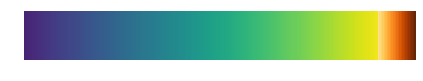

In [38]:
%matplotlib inline

# Show colorbar to include as palette

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()


In [41]:
# Write to file:

def writePalette(cols, name, colVarName, paletteName, flip=False, only_pos=False):
    '''
    Export colorbar to wb_view code: src/Files/PaletteFile.cxx
    
    name = 'Daniel Margulies'
    colVarName = 'mymap'
    paletteName = 'margulies'
    cols = n x 3 or 4 matrix with rgb values between 0 and 1
    flip = False # if True, reverse order of colorbar
    only_pos = False # if True, compress colorbar to only positive values
    '''
    
    with open('src/Files/PaletteFile.cxx', 'r') as file:
        data = file.readlines()
    
    start = 933
    
    data.insert(start, '    //------------------------------------------------------------------------\n')
    data.insert(start+1, '    //\n')
    data.insert(start+2, '    // Palette by %s\n' % name)
    data.insert(start+3, '    //\n')
    start += 4

    # being reading in color values as rgb
    g = [f for f in cols[:,0:3] * 255]
    
    if flip:
        g = np.flipud(g)

    m = []
    for x in g:
        n = []
        for h in x:
            n.append(hex(int(h)))
        m.append(n)

    for n, x in enumerate(m):
        data.insert(start, '    int %s%s[3] = { %s, %s, %s };\n' % (colVarName,n,x[0],x[1],x[2]))
        data.insert(start+1, '    this->addColor("_%s%s", %s%s);\n' % (colVarName,n,colVarName,n))
        start += 2

    data.insert(start, '    if (this->getPaletteByName("%s") == NULL) {\n' % paletteName)
    data.insert(start+1, '        Palette %s;\n' % colVarName)
    data.insert(start+2, '        %s.setName("%s");\n' % (colVarName, paletteName))
    start += 3

    if only_pos:
        sca = 1.
    else:
        sca = 2.
        
    for n, x in enumerate(m):
        data.insert(start, '        %s.addScalarAndColor( %ff, "_%s%s");\n' % (colVarName, (1-(n*1./(np.shape(cols)[0])*sca)), colVarName, n))
        start += 1

    data.insert(start, '        addPalette(%s);\n' % colVarName)
    data.insert(start+1, '    }\n')
    start += 2

    with open('src/Files/PaletteFile.cxx', 'w') as file:
        file.writelines(data)

In [32]:
writePalette(cols, 'Daniel Margulies', 'mymap', 'margulies')
writePalette(cols, 'Daniel Margulies', 'mymapInv', 'margulies_inv', flip=True)
writePalette(cols, 'Daniel Margulies', 'mymapInvPos', 'margulies_inv_pos', flip=True, only_pos=True)
writePalette(cols, 'Daniel Margulies', 'mymapPos', 'margulies_pos', only_pos=True)